# Entrainement d'un Processus Gaussien "maison" avec tf.distribution.MVN

On veut vérifier que l'on sait entraîner proprement un processus Gaussien "à la main" en encodant une tf.distribution.MVN et en apprenant les paramètres du kernel par maximisation du likelihood

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

from gpvae_lib import GPNullMean, CauchyKernel, GaussianKernel

In [2]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float64)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 4090
Total GPU Memory: 23.6 GB


In [158]:
N_POINTS = 1000
n_steps = N_POINTS
n_ahead = 50
n_series = 100

def generate_time_series(batch_size, n_steps, noise=0.05):
    """Utility function to generate time series data.

    Args:
        batch_size (int): number of time series to generate (btach size)
        n_steps (_type_): length of each time series
    """
    
    f1,f2,o1,o2 = np.random.rand(4, batch_size, 1)  # return 4 values for each time series
    time = np.linspace(0, 1, n_steps)  # time vector
    
    series = 0.4 * np.sin((time - o1) * (f1 * 5 + 10)) # first sine wave
    series += 0.2 * np.sin((time - o2) * (f2 * 20 + 20)) # second sine wave
    series += noise * (np.random.randn(batch_size, n_steps) - 0.5)  # add noise
    
    return series

In [159]:
s = generate_time_series(n_series, n_steps+n_ahead)

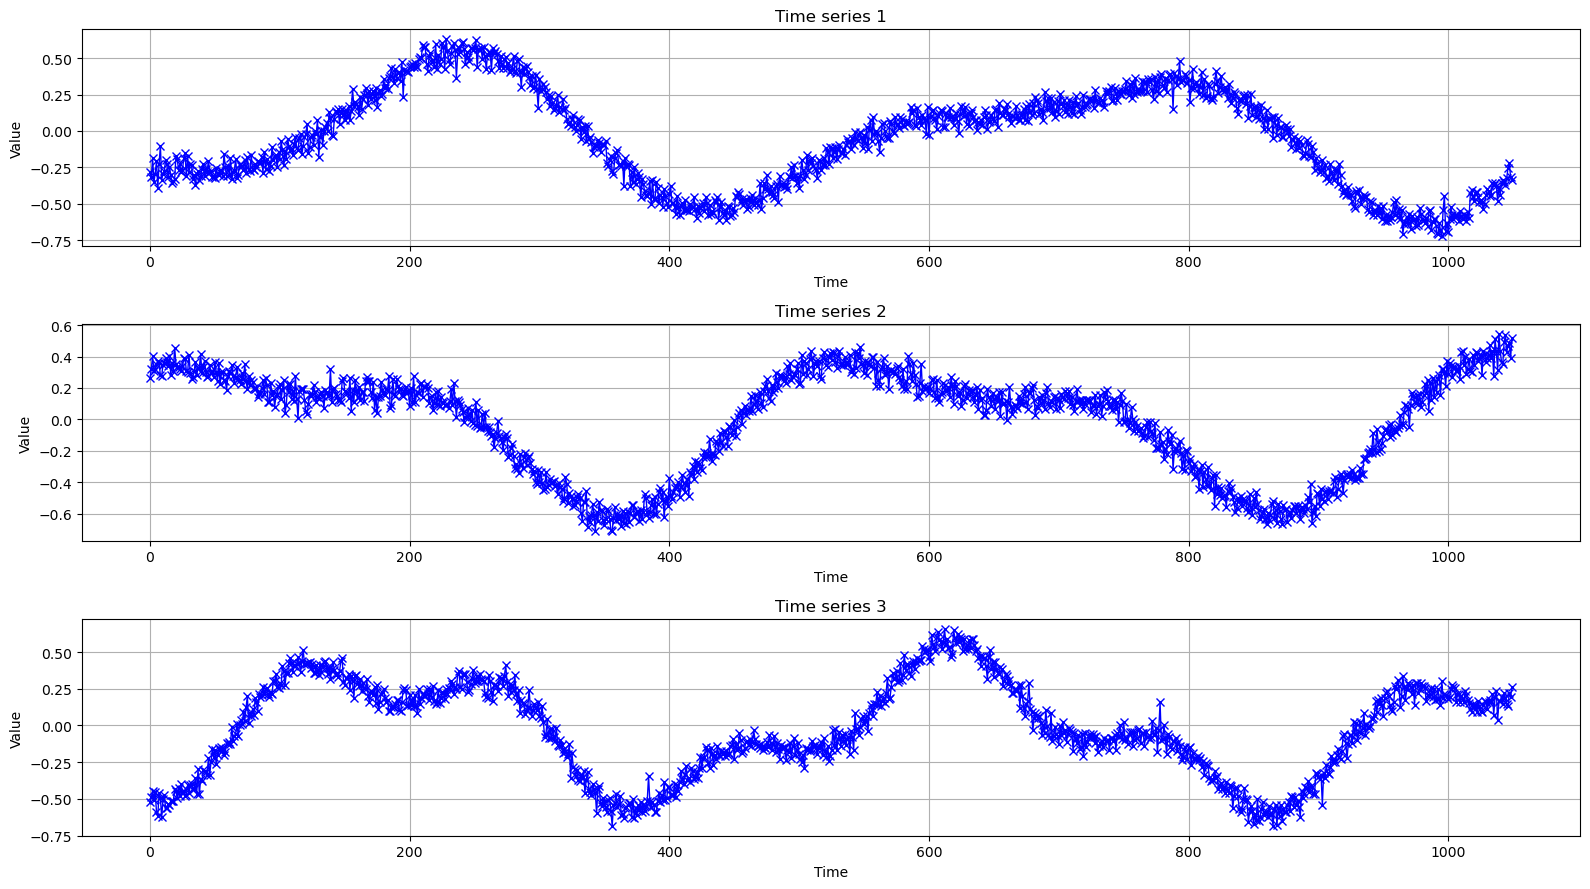

In [160]:
N = 3
fig, axs = plt.subplots(N, 1, figsize=(16, 3 * N))
for i in range(N):
    axs[i].plot(s[i], color='blue', marker="x", linewidth=1)
    axs[i].set_title(f"Time series {i+1}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Value")
    axs[i].grid(True)
plt.tight_layout()
plt.show()

In [161]:
cutoff = int(0.8 * n_series)

X_train, y_train = s[:cutoff,:n_steps], s[:cutoff,n_steps:]
X_valid, y_valid = s[cutoff:,:n_steps], s[cutoff:,n_steps:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

X_train shape: (80, 1000)
y_train shape: (80, 50)
X_valid shape: (20, 1000)
y_valid shape: (20, 50)


In [162]:
# form datasets, dataloaders, etc

BATCH_SIZE = 16  # 8192 ok sur RTX3080 et 150 time steps

from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).to(device)
        self.y = torch.tensor(y).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## On apprend le PG sur une time serie

In [202]:
mean = GPNullMean()
kernel = GaussianKernel(lengthscale=1e+0, variance=1e+0)
# kernel = CauchyKernel(lengthscale=1e+0, variance=1e+0)

In [203]:
# fonction simple
# times = torch.linspace(0, 1, n_steps).unsqueeze(0).to(device)  # (1, n_steps)
# targets = times * torch.sin(4 * 2 * torch.pi * times).to(device)  # (1, n_steps)

# sample sinusoïdes compliquées
id = np.random.randint(0, cutoff)
times = torch.linspace(0, 1, n_steps).unsqueeze(0).to(device)  # (1, n_steps)
targets = torch.tensor(X_train[id,:]).unsqueeze(0).to(device)  # (1, n_steps)

In [204]:
N_SAMPLES = np.random.randint(1, 30)  # random number of samples between 1 and 30
idx = np.random.choice(N_POINTS, N_SAMPLES, replace=False)
train_times = times[:, idx]  # (1, N_SAMPLES)
train_targets = targets[:, idx]  # (1, N_SAMPLES)

print(f"Using {N_SAMPLES} samples for training")

Using 14 samples for training


In [205]:
# learnable parameters : kernel parameters only
optimizer = torch.optim.Adam(kernel.parameters(), lr=1e-2)

In [206]:
# Train the GP model to get the kernel parameters

n_epochs = int(1e+7)  # number of epochs for training
kernel.train()  # set the kernel in training mode
losses = []  # to store the losses
lengthscales = []  # to store the lengthscales
variances = []  # to store the variances

prev_loss = float('inf')  # initialize previous loss to infinity

for epoch in range(n_epochs):  # number of epochs

    # compute the mean of the GP
    loc = mean(train_times)  # (1, N)

    # compute the covariance matrix of the GP
    covar, L = kernel(train_times, train_times)  # (1, N, N)

    # check
    assert L is not None, "Cholesky decomposition failed, L should not be None."

    # instantiate the GP prior with the lower traingular matrix L from Cholesky decomposition
    gp = torch.distributions.MultivariateNormal(loc, scale_tril=L)

    # compute the log likelihood of the GP prior
    log_likelihood = gp.log_prob(train_targets)  # (1,)

    # get the loss
    loss = -log_likelihood.mean()  # mean over the batch
    
    # backpropagation
    optimizer.zero_grad()  # zero the gradients
    loss.backward()  # backpropagation
    optimizer.step()  # update the parameters
    
    # report out metrics
    losses.append(loss.item())
    lengthscales.append(kernel.lengthscale.item())
    variances.append(kernel.variance.item())
    
    print(f"Epoch {epoch+1:>5}/{n_epochs:>5}, Loss: {loss.item():.10f}, Lengthscale: {kernel.lengthscale.item():.10f}, Variance: {kernel.variance.item():.10f}")
    
    # should we stop
    if epoch > 0 and abs(loss.item() - prev_loss) < 1e-8:
        print(f"Early stopping at epoch {epoch+1} with loss {loss.item():.4f}")
        break
    else:
        prev_loss = loss.item()

Epoch     1/10000000, Loss: 543.0831967927, Lengthscale: 0.9900000000, Variance: 1.0100000000
Epoch     2/10000000, Loss: 541.3369866642, Lengthscale: 0.9799904768, Variance: 1.0200058681
Epoch     3/10000000, Loss: 539.5094378322, Lengthscale: 0.9699651070, Variance: 1.0300215088
Epoch     4/10000000, Loss: 537.5954880058, Lengthscale: 0.9599176176, Variance: 1.0400507823
Epoch     5/10000000, Loss: 535.5898064471, Lengthscale: 0.9498418102, Variance: 1.0500974754
Epoch     6/10000000, Loss: 533.4867766093, Lengthscale: 0.9397315822, Variance: 1.0601652735
Epoch     7/10000000, Loss: 531.2804752630, Lengthscale: 0.9295809468, Variance: 1.0702577357
Epoch     8/10000000, Loss: 528.9646465708, Lengthscale: 0.9193840496, Variance: 1.0803782719
Epoch     9/10000000, Loss: 526.5326691090, Lengthscale: 0.9091351813, Variance: 1.0905301244
Epoch    10/10000000, Loss: 523.9775132618, Lengthscale: 0.8988287867, Variance: 1.1007163544
Epoch    11/10000000, Loss: 521.2916857626, Lengthscale: 0.8

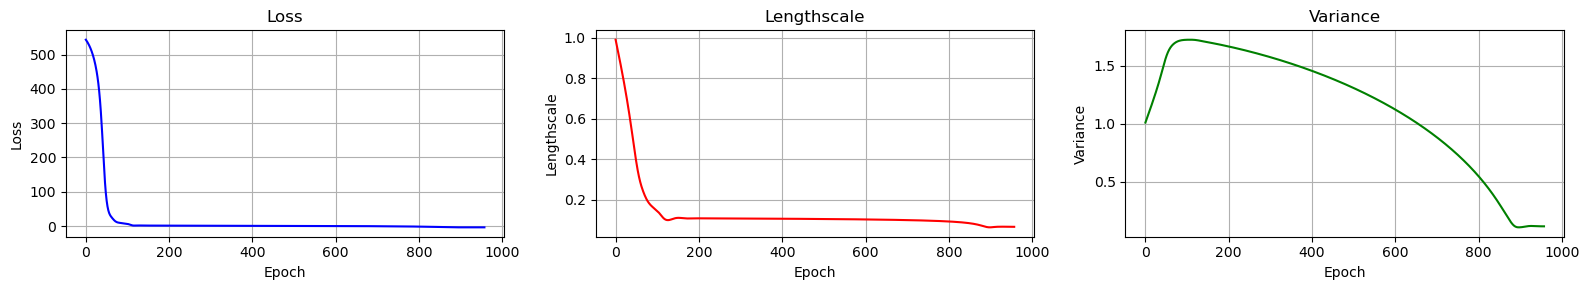

In [207]:
fig, ax = plt.subplots(1,3, figsize=(16, 3))
                       
ax[0].plot(losses, color='blue')
ax[0].set_title("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid(True)

ax[1].plot(lengthscales, color='red')
ax[1].set_title("Lengthscale")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Lengthscale")
ax[1].grid(True)

ax[2].plot(variances, color='green')
ax[2].set_title("Variance")
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Variance")
ax[2].grid(True)

plt.tight_layout()
plt.show()

In [208]:
# compute predictions
N_POINTS = 1000  # number of points to predict
TIMES = 1.25  # nombre d'intervalles au-delà des données d'entraînement

all_times = torch.linspace(0, 1 * TIMES, N_POINTS).to(device).unsqueeze(0)  # shape (1, n_steps)

k_1_1, _ = kernel(train_times, train_times)  # (1, N, N)
k_2_1, _ = kernel(all_times, train_times)  # (1, N_POINTS, N)
k_1_2 = k_2_1.transpose(-1, -2)  # (1, N, N_POINTS)
k_2_2, _ = kernel(all_times, all_times)  # (1, N_POINTS, N_POINTS)

posterior_mean = k_2_1 @ (torch.linalg.inv(k_1_1) @ train_targets.unsqueeze(-1))  # (1, N_POINTS)
posterior_cov = k_2_2 - k_2_1 @ torch.linalg.solve(k_1_1, k_1_2)  # (1, N_POINTS, N_POINTS)

# instantiate the GP posterior with the posterior mean and covariance
gp_posterior = torch.distributions.MultivariateNormal(posterior_mean.squeeze(-1), scale_tril=torch.linalg.cholesky(posterior_cov))

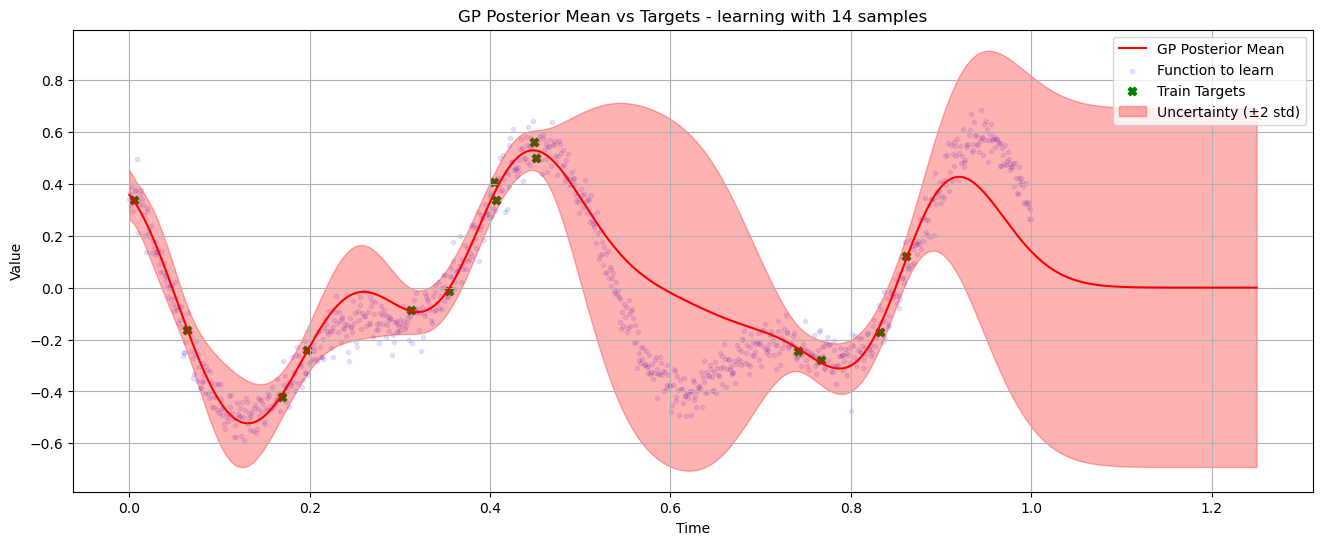

In [209]:
# sample from the posterior and display the predictions

preds = gp_posterior.sample()  # (1, N_POINTS)

fig, axs = plt.subplots(1, 1, figsize=(16, 6))

axs.plot(all_times.cpu().numpy().squeeze(), posterior_mean.squeeze().detach().cpu().numpy(), color='red', label='GP Posterior Mean')
axs.scatter(times.cpu().numpy().squeeze(), targets.cpu().numpy().squeeze(), color='blue', alpha=0.10, marker='.', label='Function to learn')
axs.scatter(train_times.cpu().numpy().squeeze(), train_targets.cpu().numpy().squeeze(), color='green', marker='X', label='Train Targets')
axs.fill_between(all_times.cpu().numpy().squeeze(),
                 (posterior_mean.squeeze().detach().cpu().numpy() - 2 * np.sqrt(torch.diagonal(posterior_cov, dim1=-2, dim2=-1).squeeze().detach().cpu().numpy())),
                 (posterior_mean.squeeze().detach().cpu().numpy() + 2 * np.sqrt(torch.diagonal(posterior_cov, dim1=-2, dim2=-1).squeeze().detach().cpu().numpy())),
                 color='red', alpha=0.3, label='Uncertainty (±2 std)')
plt.legend()
plt.title(f"GP Posterior Mean vs Targets - learning with {N_SAMPLES} samples")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.show()